[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb)

# Research Agent in LangGraph, retrieve information from different LLMs and web search

Inspired by https://www.pinecone.io/learn/langgraph-research-agent/

**Research agents** are multi-step LLM agents that through multiple steps can produce in depth research reports on a topic of our choosing.

LangGraph agent that retrieve information form different LLMs and Tavily web search in order to respond to the request of the user.

So you need the keys to call the API of OpenAI and Tavily.

In [1]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

Please provide your OPENAI_API_KEY ········
Please provide your TAVILY_API_KEY ········


## Graph State

We will define a custom graph state to support our agent-oriented decision making.

In [85]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

There are four parts to our agent state, those are:

* `input`: this is the user's most recent query, usually this would be a question that we want to answer with our research agent.
* `chat_history`: we are building a conversational agent that can support multiple interactions, to allow previous interactions to provide additional context throughout our agent logic we include the chat history in the agent state.
* `intermediate_steps`: provides a record of all steps the research agent will take between the user asking a question via `input` and the agent providing a final answer. These intermediate steps are crucial to allowing the agent to follow a path of coherent actions and ultimately producing an informed final answer.

## Custom Tools

We will define several tools for this agent that will focus on initial data discovery, that will allow the LLM to use more tools to research more deeply via a variety of different routes.

### General LLM Knowledge

Retrieve from the general knwoledge of different models (llama3.2:latest, mistral:latest, gpt-4o-mini)

You need to install Ollama https://ollama.com/
and pull the models

`ollama pull llama3.2`

`ollama pull mistral`

In [86]:
from langchain_ollama import ChatOllama

llmOlama = ChatOllama(model="llama3.2:latest")
results = llmOlama.invoke("What is LangGraph?")
print(results)
print(results.content)

content="LangGraph is an open-source graph database written in Rust, designed to provide high performance and scalability for storing and querying large amounts of graph data. It's a relatively new project, launched in 2021, but has gained popularity quickly due to its innovative architecture and impressive performance.\n\nKey features of LangGraph include:\n\n1. **High-performance**: LangGraph is optimized for storage and query performance, making it suitable for large-scale applications.\n2. **Graph database**: LangGraph provides a graph database interface, allowing users to store and query graph data using standard SQL-like queries.\n3. **Scalability**: LangGraph is designed to scale horizontally, making it suitable for big data applications with high concurrency.\n4. **ACID compliance**: LangGraph guarantees atomicity, consistency, isolation, and durability (ACID) properties to ensure data integrity.\n5. **High availability**: LangGraph provides support for distributed transactions

Format the result

In [87]:
contexts = f"{results.content}\n[Info provided by {llmOlama.model}]"
print(contexts)

LangGraph is an open-source graph database written in Rust, designed to provide high performance and scalability for storing and querying large amounts of graph data. It's a relatively new project, launched in 2021, but has gained popularity quickly due to its innovative architecture and impressive performance.

Key features of LangGraph include:

1. **High-performance**: LangGraph is optimized for storage and query performance, making it suitable for large-scale applications.
2. **Graph database**: LangGraph provides a graph database interface, allowing users to store and query graph data using standard SQL-like queries.
3. **Scalability**: LangGraph is designed to scale horizontally, making it suitable for big data applications with high concurrency.
4. **ACID compliance**: LangGraph guarantees atomicity, consistency, isolation, and durability (ACID) properties to ensure data integrity.
5. **High availability**: LangGraph provides support for distributed transactions and replication,

We put this process in a tool

In [88]:
from langchain_core.tools import tool
from langchain_ollama import ChatOllama

@tool("llm_knowledge_llama")
def llm_knowledge_llama(query: str):
    """Finds general knowledge information using the knowlwdge of the LLM llama3.2, it's an inexpensive tool, but not very powerful."""
    try:
        llmLlama = ChatOllama(model="llama3.2:latest")
        results = llmLlama.invoke(query)
        contexts = f"{results.content}\n[Info provided by {llmLlama.model}]"
    except Exception as e:
        print(f"Error: {str(e)}")
        contexts = f"Error: {str(e)}"
    return contexts
    
@tool("llm_knowledge_mistral")
def llm_knowledge_mistral(query: str):
    """Finds general knowledge information using the knowlwdge of the LLM mistral, it's an inexpensive tool, but not very powerful."""
    try:
        llmMistral = ChatOllama(model="mistral:latest")
        results = llmMistral.invoke(query)
        contexts = f"{results.content}\n[Info provided by {llmMistral.model}]"
    except Exception as e:
        print(f"Error: {str(e)}")
        contexts = f"Error: {str(e)}"
    return contexts

@tool("llm_knowledge_gpt4o")
def llm_knowledge_gpt4o(query: str):
    """Finds general knowledge information using the knowlwdge of the LLM GTP-4o.mini, it's an expensive tool, but more powerful.
    Use this tool if you have not gotten relevant information from other tools"""
    try:
        llm = ChatOpenAI(model="gpt-4o-mini")
        results = llm.invoke(query)
        contexts = f"{results.content}\n[Info provided by gpt-4o-mini]"
    except Exception as e:
        print(f"Error: {str(e)}")
        contexts = f"Error: {str(e)}"
    return contexts

In [90]:
print(llm_knowledge_llama.invoke("What is LangGraph?"))

LangGraph is an open-source, Python-based library for building graph databases. It's designed to be a high-performance and efficient alternative to other graph database solutions.

LangGraph provides a simple and intuitive API for creating, querying, and managing graphs. It supports various data types, including nodes, edges, and properties, and offers features like indexing, caching, and query optimization.

Some key benefits of LangGraph include:

1. **Efficient data storage**: LangGraph uses an optimized data structure to store graph data, which results in fast query performance.
2. **Flexible schema design**: LangGraph allows for dynamic schema design, making it easy to adapt to changing data structures.
3. **Scalability**: LangGraph is designed to handle large-scale graph datasets, making it suitable for big data applications.
4. **Easy integration with Python**: LangGraph provides a simple and intuitive API, allowing developers to easily integrate it into their Python-based proje

### Web Search

The web search tool will provide the agent with access to web search. It will be instructed to use this for more general knowledge queries.

In [91]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search = TavilySearchResults(max_results=3, include_answer=True, include_raw_content=True, include_images=True)
results = web_search.invoke("What is LangGraph?")
print(results)

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial', 'content': 'LangGraph is a library within the LangChain ecosystem designed to tackle these challenges head-on. LangGraph provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured manner.'}, {'url': 'https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787', 'content': "LangGraph is a low-level framework that offers extensive customisation options, allowing you to build precisely what you need. Since LangGraph is built on top of LangChain, it's seamlessly integrated into its ecosystem, making it easy to leverage existing tools and components. However, there are areas where LangGrpah could be improved:"}, {'url': 'https://medium.com/@gopiariv/langgraph-a-beginners-guide-to-building-ai-workflows-e500965f2ef9', 'content': "LangGraph is a part of the LangChain ecosystem, but it's installed separately from the main LangChain package. Here's a gu

In [92]:
contexts = "\n---\n".join(
    ["\n".join([x["content"], x["url"]]) for x in results]
)

print(contexts)

LangGraph is a library within the LangChain ecosystem designed to tackle these challenges head-on. LangGraph provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured manner.
https://www.datacamp.com/tutorial/langgraph-tutorial
---
LangGraph is a low-level framework that offers extensive customisation options, allowing you to build precisely what you need. Since LangGraph is built on top of LangChain, it's seamlessly integrated into its ecosystem, making it easy to leverage existing tools and components. However, there are areas where LangGrpah could be improved:
https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787
---
LangGraph is a part of the LangChain ecosystem, but it's installed separately from the main LangChain package. Here's a guide on how to install LangGraph: 1.
https://medium.com/@gopiariv/langgraph-a-beginners-guide-to-building-ai-workflows-e500965f2ef9


We put this process into a tool:

In [93]:
from langchain_core.tools import tool

@tool("web_search")
def web_search(query: str):
    """Finds general knowledge information using Tavily Web Search. Can also be used
    to augment more 'general' knowledge to a previous specialist query.
    It's an inexpensive tool, but it can find recent and niche information."""
    web_search = TavilySearchResults(max_results=3, include_answer=True, include_raw_content=True, include_images=True)
    results = web_search.invoke(query)
    contexts = "\n---\n".join(
        ["\n".join([x["content"], x["url"]]) for x in results]
    )
    return contexts

### Final Answer

Finally, we define a "final answer" tool. This isn't a tool in the usual sense, instead we use it to force a particular output format from our LLM via the function/tool calling.

In [94]:
@tool("final_answer")
def final_answer(
    introduction: str,
    research_steps: str,
    main_body: str,
    conclusion: str,
    differences: str,
    sources: str
):
    """Returns a natural language response to the user in the form of a research
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the user's question and the
    topic we are researching.
    - `research_steps`: a few bullet points explaining the steps that were taken
    to research your report.
    - `main_body`: this is where the bulk of high quality and concise
    information that answers the user's question belongs. It is 3-4 paragraphs
    long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on what was found.
    - `differences`: any differences between the information taken from the different
    sources, if there are no differences that the sources are not inconsistent with each other.
    - `sources`: a bulletpoint list provided detailed sources for all information
    referenced during the research process, please for LLM indacate the model used.
    """
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return ""

## Initialize the "Oracle"

The **Oracle** LLM is our graph's decision maker. It decides which path we should take down our graph. It functions similarly to an agent but is much simpler and reliable.

The Oracle consists of an LLM provided with a set of potential function calls (ie our tools) that it can decide to use — we force it to use _at least_ one of those tool using the `tool_choice="any"` setting (see below). Our Oracle only makes the decision to use a tool, it doesn't execute the tool code itself (we do that seperately in our graph).

### Oracle Prompt

Our prompt for the Oracle will emphasize it's decision making ability within the `system_prompt`, leave a placeholder for us to later insert `chat_history`, and provide a place for us to insert the user `input`.

In [95]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, use the
llm knowledge tool only once for a model (ie, if the tool appears in the 
scratchpad once, do not use it again, but you can use different models) 
for other tools do NOT use more than twice (ie, if the tool appears in the 
scratchpad twice, do not use it again).
If the request is very specific it is preferable to use the most powerful tool 
even if more expensive.

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool.
Start looking for information from the cheapest tools.
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

Next, we must initialize our `llm` (for this we use `gpt-4o`) and then create the _runnable_ pipeline of our Oracle.

The runnable connects our inputs (the user `input` and `chat_history`) to our `prompt`, and our `prompt` to our `llm`. It is also where we _bind_ our tools to the LLM and enforce function calling via `tool_choice="any"`.

Test the agent quickly to confirm it is functional:

In [96]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0
)

tools=[
    llm_knowledge_gpt4o,
    llm_knowledge_llama,
    llm_knowledge_mistral,
    web_search,
    final_answer
]

# define a function to transform intermediate_steps from list
# of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

In [97]:
inputs = {
    "input": "What is LangGraph?",
    "chat_history": [],
    "intermediate_steps": [],
}
out = oracle.invoke(inputs)
out

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rqNufNWBk624QCweHuQcOpbo', 'function': {'arguments': '{"query": "What is LangGraph?"}', 'name': 'llm_knowledge_llama'}, 'type': 'function'}, {'id': 'call_cMXABVceQES076MNgYzxZDLI', 'function': {'arguments': '{"query": "What is LangGraph?"}', 'name': 'llm_knowledge_mistral'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 705, 'total_tokens': 766, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_143bb8492c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-985b8534-599f-4d1f-89e1-a9f7671ff89f-0', tool_calls=[{'name': 'llm_knowledge_llama', 'args': {'query': 'What is LangGraph?'}, 'id': 'call_rqNufNWBk624QCweHuQcOpbo', 'type': 'tool_call'}, {'name': 'llm_knowledge_mistral', 'args': {'que

It is running but we are returning a lot of output here, we can narrow this down to what we need — ie, the chosen tool name and generated input args for the tool.

In [98]:
for index, call in enumerate(out.tool_calls, start=1):
    print(f"{index}. {call.get('name', 'not found')} {call.get('args', '')}")

1. llm_knowledge_llama {'query': 'What is LangGraph?'}
2. llm_knowledge_mistral {'query': 'What is LangGraph?'}


We can see now that our Oracle decided to use the cheapest tool.

## Define Nodes for Graph

We will be passing the tool use decision to our `router` which will _route_ the output to the chosen node component to run (we define these below) based on the `out.tool_calls[0]["name"]` value.

In [99]:
def run_oracle(state: list):
    print("run_oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"

All of our tools can be run using the same function logic, which we define with `run_tool`. The input parameters to our tool call and the resultant output are added to our graph state's `intermediate_steps` parameter.

In [100]:
tool_str_to_func = {
    "llm_knowledge_gpt4o": llm_knowledge_gpt4o,
    "llm_knowledge_llama": llm_knowledge_llama,
    "llm_knowledge_mistral": llm_knowledge_mistral,
    "web_search": web_search,
    "final_answer": final_answer
}

def run_tool(state: list):
    # use this as helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}

## Define Graph

In [101]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("llm_knowledge_gpt4o", run_tool)
graph.add_node("llm_knowledge_llama", run_tool)
graph.add_node("llm_knowledge_mistral", run_tool)
graph.add_node("web_search", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

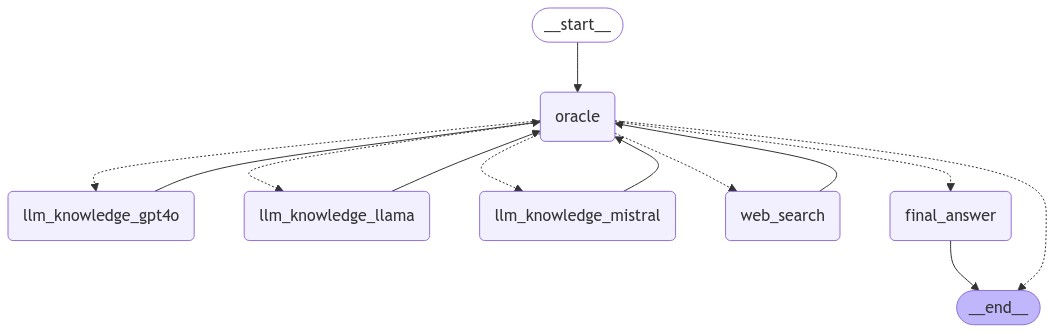

In [102]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))


## Building Reports

Let's test our research agent. First, I want to try on something simple (although not within the intended use-case of our agent):

In [103]:
out = runnable.invoke({
    "input": "What is LangGraph?",
    "chat_history": [],
})

run_oracle
intermediate_steps: []
llm_knowledge_llama.invoke(input={'query': 'LangGraph'})
run_oracle
intermediate_steps: [AgentAction(tool='llm_knowledge_llama', tool_input={'query': 'LangGraph'}, log='TBD'), AgentAction(tool='llm_knowledge_llama', tool_input={'query': 'LangGraph'}, log="LangGraph is a Python library used for graph analysis and manipulation. It allows users to create, manipulate, and analyze graphs from various data formats, including edge lists, adjacency matrices, and CSV files.\n\nKey Features of LangGraph:\n\n1. **Graph Creation**: LangGraph provides an efficient way to create graphs from scratch or by reading existing graph data.\n2. **Graph Manipulation**: The library offers a range of functions for modifying graph structures, such as adding or removing edges, nodes, and communities.\n3. **Graph Analysis**: LangGraph includes tools for analyzing graph properties, including degree distribution, clustering coefficient, and community detection.\n4. **Visualization*

Let's create a function to consume the agent output and format it into our report:

In [104]:
def build_report(output: dict):
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    sources = output["sources"]
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return f"""
INTRODUCTION
------------
{output["introduction"]}

RESEARCH STEPS
--------------
{research_steps}

REPORT
------
{output["main_body"]}

CONCLUSION
----------
{output["conclusion"]}

DIFFERENCES
----------
{output["differences"]}

SOURCES
-------
{sources}
"""

In [105]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
LangGraph is a versatile tool used in the field of graph analysis and multi-agent application development. It serves different purposes depending on the context, from graph manipulation to building complex language model applications.

RESEARCH STEPS
--------------
- Conducted a search using the Llama LLM to gather basic information about LangGraph as a Python library for graph analysis.
- Performed a web search to find more recent and specific information about LangGraph's applications in multi-agent systems and language model frameworks.

REPORT
------
LangGraph is a Python library that provides tools for graph analysis and manipulation. It allows users to create, manipulate, and analyze graphs from various data formats, including edge lists, adjacency matrices, and CSV files. The library is optimized for performance, making it suitable for large-scale graph analysis tasks. It supports a wide range of graph data formats and allows users to create custom gra

Now let's try with an on-topic question on AI.

In [106]:
out = runnable.invoke({
    "input": "tell me more about Cycles and Branching in LangGraph",
    "chat_history": []
})

run_oracle
intermediate_steps: []
llm_knowledge_llama.invoke(input={'query': 'Cycles and Branching in LangGraph'})
run_oracle
intermediate_steps: [AgentAction(tool='llm_knowledge_llama', tool_input={'query': 'Cycles and Branching in LangGraph'}, log='TBD'), AgentAction(tool='llm_knowledge_llama', tool_input={'query': 'Cycles and Branching in LangGraph'}, log="LangGraph is a Python library used for modeling language models, particularly those based on transformer architectures. It provides an efficient way to represent complex graph structures that are commonly found in natural language processing tasks.\n\nIn this answer, we'll explore how cycles and branching can be represented and utilized in LangGraph.\n\n**Cycles**\n\nA cycle in LangGraph refers to a self-looping connection between two nodes. Cycles can represent various concepts in NLP, such as:\n\n*   **Context-dependent relationships**: A relationship that depends on the context in which it is applied.\n*   **Self-referential en

In [107]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Cycles and branching are fundamental concepts in graph theory, and their application in LangGraph provides a robust framework for representing complex linguistic structures. LangGraph is a tool used to model language data as graphs, where nodes represent linguistic units and edges represent relationships between them.

RESEARCH STEPS
--------------
- Utilized the Llama3.2 model to gather initial insights on cycles and branching in LangGraph.
- Consulted the Mistral model for additional perspectives on the structural properties of LangGraph.
- Leveraged the GPT-4o model for a comprehensive understanding of the implications and management of cycles and branching in LangGraph.

REPORT
------
LangGraph is a framework that allows for the representation and manipulation of language data in graph form. This involves nodes that represent linguistic units such as words or phrases, and edges that denote relationships like syntactic or semantic connections.

Cycles in L

Let's ask about RAG specifically.

In [108]:
out = runnable.invoke({
    "input": "what is retrieval augmented generation?",
    "chat_history": []
})

run_oracle
intermediate_steps: []
llm_knowledge_llama.invoke(input={'query': 'retrieval augmented generation'})
run_oracle
intermediate_steps: [AgentAction(tool='llm_knowledge_llama', tool_input={'query': 'retrieval augmented generation'}, log='TBD'), AgentAction(tool='llm_knowledge_llama', tool_input={'query': 'retrieval augmented generation'}, log="Retrieval Augmented Generation (RAG) is a novel approach to natural language processing (NLP) that combines the strengths of retrieval and generation. The core idea behind RAG is to use a retrieval model to retrieve relevant information from a large knowledge base, and then use this retrieved information as input to generate new text.\n\nThe traditional approach in NLP typically involves generating text from scratch using a language model. However, RAG takes a different approach by using the retrieved information as a starting point for generation. This allows the model to leverage pre-existing knowledge and avoid redundant or repetitive c

In [109]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Retrieval Augmented Generation (RAG) is an innovative approach in natural language processing (NLP) that combines retrieval and generation techniques to enhance text generation tasks.

RESEARCH STEPS
--------------
- Utilized the LLM knowledge of llama3.2 to gather an initial understanding of RAG.
- Consulted the LLM knowledge of mistral to gain additional insights and confirm the information obtained.

REPORT
------
Retrieval Augmented Generation (RAG) is a model architecture that integrates the capabilities of retrieval and generation models to improve the performance of text-to-text models. The core concept of RAG is to use a retrieval model to fetch relevant information from a large knowledge base, which is then used as input for generating new text. This approach allows the model to leverage external knowledge beyond its training data, enhancing its ability to handle open-domain questions and tasks requiring specific or detailed information.

The process

Let's ask about recent financial results, probably the best source will be web search.

In [110]:
out = runnable.invoke({
    "input": "provide information about Microsoft's 2024 financial results",
    "chat_history": []
})

run_oracle
intermediate_steps: []
web_search.invoke(input={'query': 'Microsoft 2024 financial results'})
run_oracle
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'Microsoft 2024 financial results'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'Microsoft 2024 financial results'}, log='Earnings Release FY24 Q4. Microsoft Cloud Strength Drives Fourth Quarter Results. REDMOND, Wash. — July 30, 2024 — Microsoft Corp. today announced the following results for the quarter ended June 30, 2024, as compared to the corresponding period of last fiscal year: · Revenue was $64.7 billion and increased 15% (up 16% in constant currency)\nhttps://www.microsoft.com/en-us/investor/earnings/FY-2024-Q4/press-release-webcast\n---\nFor more information, financial analysts and investors only:\nInvestor Relations, Microsoft, (425) 706-4400\nFor more information, press only:\nMicrosoft Media Relations, WE Communications, (425) 638-7777, [email\xa0protected]\nNote to

In [111]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Microsoft's financial performance in 2024 has been a topic of interest for investors and analysts alike, given the company's significant role in the technology sector. This report delves into the financial results of Microsoft for the fiscal year 2024, highlighting key metrics and performance indicators.

RESEARCH STEPS
--------------
- Conducted a web search for Microsoft's 2024 financial results.
- Reviewed the official earnings release from Microsoft's Investor Relations website.
- Analyzed the revenue growth and other financial metrics reported for the fiscal year 2024.

REPORT
------
In 2024, Microsoft reported robust financial results, driven primarily by the strength of its cloud services. For the fourth quarter ending June 30, 2024, Microsoft announced a revenue of $64.7 billion, marking a 15% increase compared to the same period in the previous fiscal year. This growth was even more pronounced when adjusted for constant currency, showing a 16% increa

In [112]:
out = runnable.invoke({
    "input": "write the history of Italy",
    "chat_history": []
})

run_oracle
intermediate_steps: []
llm_knowledge_llama.invoke(input={'query': 'history of Italy'})
run_oracle
intermediate_steps: [AgentAction(tool='llm_knowledge_llama', tool_input={'query': 'history of Italy'}, log='TBD'), AgentAction(tool='llm_knowledge_llama', tool_input={'query': 'history of Italy'}, log="Italy has a rich and complex history that spans over 2,500 years. Here is a brief overview:\n\n**Ancient Italy (8th century BC - 476 AD)**\n\n* The Italian peninsula was inhabited by various tribes, including the Etruscans, Latins, and Greeks.\n* In 753 BC, Rome was founded, and it became a major power in the Mediterranean region.\n* The Roman Republic (509-27 BC) was established after the overthrow of the monarchy, and it expanded its territories through conquests and alliances.\n* The Roman Empire (27 BC-476 AD) was established under Augustus Caesar, and it reached its peak during the Pax Romana (Roman Peace).\n* Italy played a significant role in the decline and fall of the Wes

In [113]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Italy's history is a tapestry of cultural, political, and social developments that have shaped not only the nation itself but also the broader world. From its ancient roots to its modern-day status, Italy's journey is marked by significant milestones and influential periods.

RESEARCH STEPS
--------------
- Utilized the LLM knowledge of llama3.2 to gather an overview of Italy's history.
- Consulted the LLM knowledge of mistral for additional insights and details.
- Leveraged the LLM knowledge of gpt-4o-mini for a comprehensive and detailed account of Italy's historical timeline.

REPORT
------
Italy's history begins in ancient times, with the Italian Peninsula inhabited by various tribes such as the Etruscans and Italic tribes. The founding of Rome in 753 BC marked the beginning of a civilization that would grow into the Roman Republic and later the Roman Empire, dominating much of Europe, North Africa, and the Middle East. The fall of the Western Roman Empir